In [1]:
import pandas as pd
from pdvega import Axes
import numpy as np

In [2]:
scheme= ["#927E58", "#CEB37F", "#B2CC55", "#58B303", "#C09FE4", "#AEE2DF", "#DCFFED", "#F6E36A", "FCC05E"]
order = ["coal", "crude oil", "natural gas", "biomass", "nuclear", "hydro", "wind", "solar", "geothermal"]
start = "2001-01-01"
end = "2018-01-01"

In [3]:
production = pd.read_excel("energy_production-quadrillion-btu.xlsx", sheet_name="Annual Data")
production.rename({
    "Annual Total": "year",
    "Coal Production": "coal",
    "Natural Gas (Dry) Production": "natural gas",
    "Crude Oil Production": "crude oil",
    "Natural Gas Plant Liquids Production": "natural gas liquids",
    "Nuclear Electric Power Production": "nuclear",
    "Hydroelectric Power Production": "hydro",
    "Geothermal Energy Production": "geothermal",
    "Solar Energy Production": "solar",
    "Wind Energy Production": "wind",
    "Biomass Energy Production": "biomass",
}, axis=1, inplace=True)
production.drop(["Total Fossil Fuels Production", 
                 "Total Renewable Energy Production", 
                 "Total Primary Energy Production"], axis=1, inplace=True)

production.loc[production.geothermal == "Not Available", "geothermal"] = 0
production.loc[production.solar == "Not Available", "solar"] = 0
production.loc[production.wind == "Not Available", "wind"] = 0
production.head()

,year,coal,natural gas,crude oil,natural gas liquids,nuclear,hydro,geothermal,solar,wind,biomass
0,1949,11.973882,5.377243,10.683252,0.713799,0.0,1.424722,0,0,0,1.549262
1,1950,14.060135,6.232975,11.446729,0.822828,0.0,1.415411,0,0,0,1.562307
2,1951,14.419325,7.415733,13.036724,0.920369,0.0,1.423795,0,0,0,1.534669
3,1952,12.734313,7.963599,13.281049,0.997771,0.0,1.465812,0,0,0,1.474369
4,1953,12.277746,8.338838,13.671076,1.061677,0.0,1.412859,0,0,0,1.418601


In [4]:
production.year = pd.to_datetime(production.year, format="%Y")
a = production.melt(id_vars="year")
a.rename({"variable": "source", "value": "energy"}, axis=1, inplace=True)
a.source = a.source.str.replace("natural gas liquids", "natural gas")
a = a.groupby(["year", "source"]).energy.sum().reset_index()
a.energy = pd.to_numeric(a.energy * 1000)
a.head()

,year,source,energy
0,1949-01-01,biomass,1549.262
1,1949-01-01,coal,11973.882
2,1949-01-01,crude oil,10683.252
3,1949-01-01,geothermal,0.000
4,1949-01-01,hydro,1424.722


## total production of electricity in  BTU on a national scale from 2001-2017

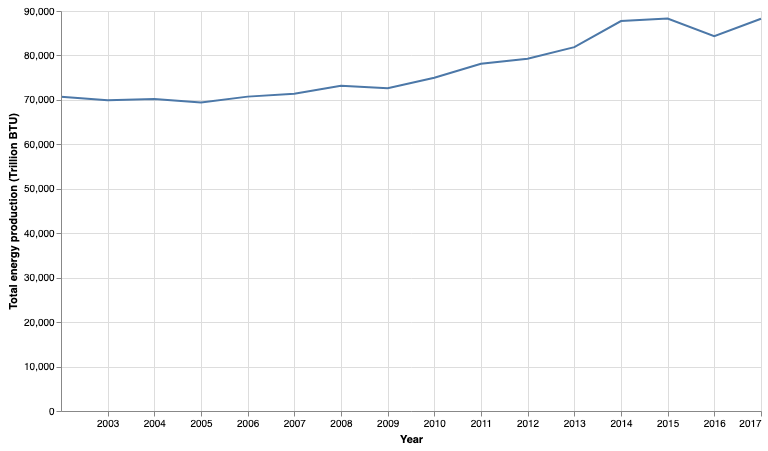

In [5]:
Axes({
    "mark": "line",
    "encoding": {
       "x": {
           "field": "year",
           "type": "temporal",
            "axis": {"title": "Year", "format": "%Y"}
       },
        "y": {
            "field": "energy",
            "type": "quantitative",
            "aggregate": "sum",
            "axis": {"title": "Total energy production (Trillion BTU)"}
        },
    },
    "height": 400,
    "width": 700
}, a[(a.year > start) & (a.year < end)])

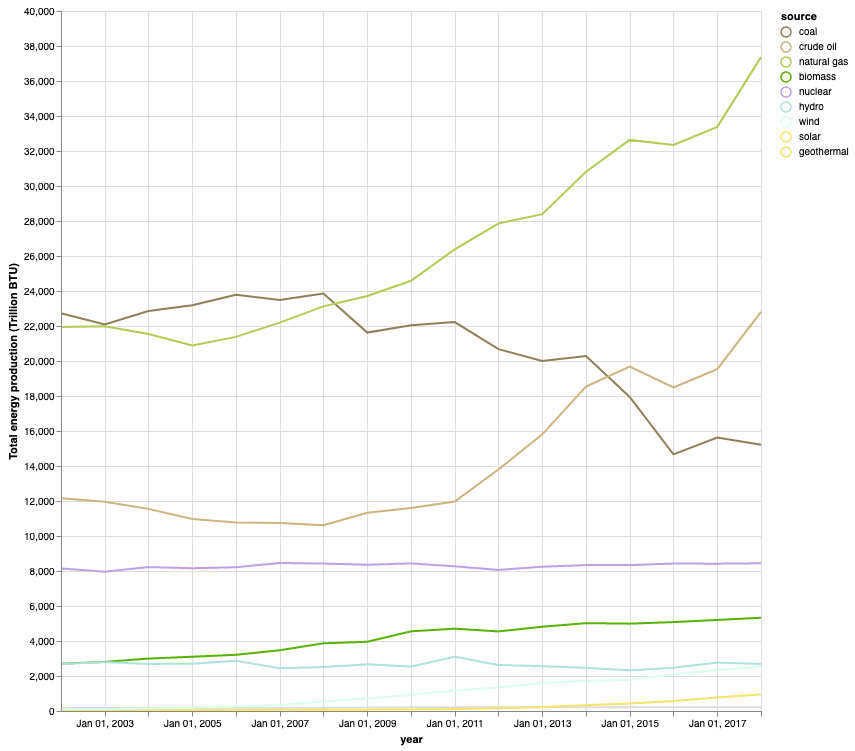

In [6]:
Axes({
    "mark": "line",
    "encoding": {
       "x": {
           "field": "year",
           "type": "temporal"
       },
        "y": {
            "field": "energy",
            "type": "quantitative",
            "axis": {"title": "Total energy production (Trillion BTU)"}
        },
        "color": {
            "field": "source",
            "scale": {"range": scheme},
            "sort": order
        }
    },
    "height": 700,
    "width": 700
}, a[a.year > start])

In [7]:
a[(a.year > start) & (a.year < end)].to_csv("../static/data/A.csv", header=True, index=False, float_format="%.0f")

In [8]:
b = a.copy()
a_total = a.groupby("year").energy.sum()
b["total"] = b.year.map(a_total)
b["share"] = b.energy / b.total
b.head()

,year,source,energy,total,share
0,1949-01-01,biomass,1549.262,31722.16,0.048838
1,1949-01-01,coal,11973.882,31722.16,0.377461
2,1949-01-01,crude oil,10683.252,31722.16,0.336776
3,1949-01-01,geothermal,0.000,31722.16,0.000000
4,1949-01-01,hydro,1424.722,31722.16,0.044913


## percentage that each energy sources makes up of total energy production on national scale

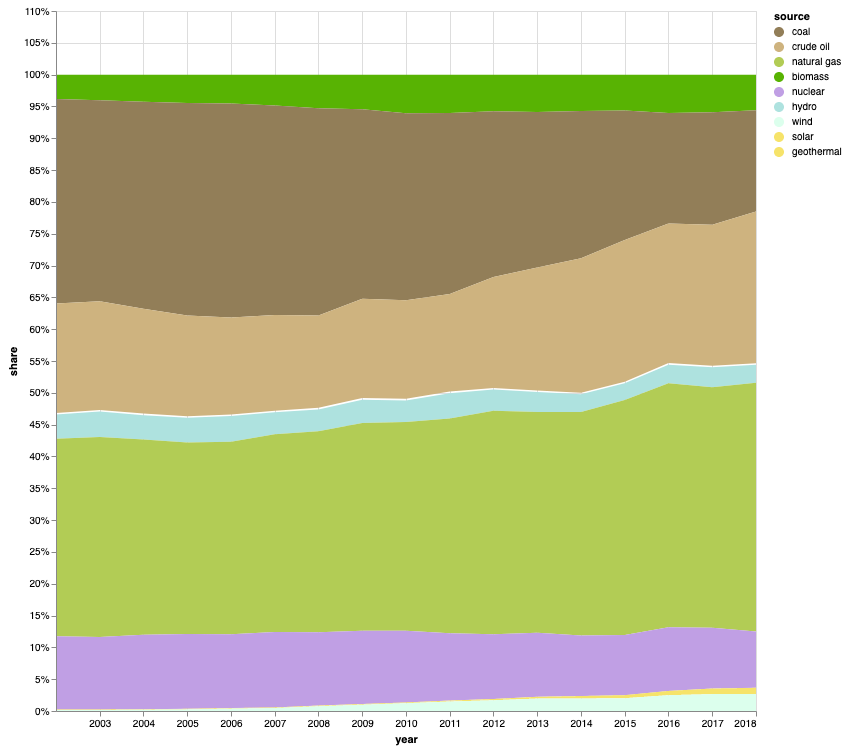

In [9]:
Axes({
    "mark": "area",
    "encoding": {
       "x": {
           "field": "year",
           "type": "temporal",
            "axis": {"format": "%Y"}
       },
        "y": {
            "field": "share",
            "type": "quantitative",
            "axis": {"format": ".0%"}
        },
        "color": {
            "field": "source",
            "scale": {"range": scheme},
            "sort": order
        }
    },
    "height": 700,
    "width": 700
}, b[b.year > start])

In [10]:
c = b.copy()
c.share = pd.to_numeric(c.share * 100)
c[(c.year > start) & (c.year < end)].drop(["energy", "total"], axis=1).to_csv("../static/data/B.csv", 
                                                               header=True, index=False, float_format='%.3f')

In [11]:
states = pd.read_excel("states-mwh.xls", sheet_name="Net_Generation_1990-2017 Final")
states.rename({
    "YEAR": "year",
    "STATE": "state",
    "ENERGY SOURCE": "source",
    "GENERATION (Megawatthours)": "energy",
    "TYPE OF PRODUCER": "producer"
}, axis=1, inplace=True)
states.year = pd.to_datetime(states.year, format="%Y")
states = states[states.producer == "Total Electric Power Industry"].copy().drop("producer", axis=1)
states.head()

,year,state,source,energy
0,1990-01-01,AK,Total,5599506.0
1,1990-01-01,AK,Coal,510573.0
2,1990-01-01,AK,Hydroelectric Conventional,974521.0
3,1990-01-01,AK,Natural Gas,3466261.0
4,1990-01-01,AK,Petroleum,497116.0


In [12]:
states.source.unique()

array(['Total', 'Coal', 'Hydroelectric Conventional', 'Natural Gas',
       'Petroleum', 'Wind', 'Wood and Wood Derived Fuels', 'Nuclear',
       'Other Biomass', 'Other Gases', 'Pumped Storage', 'Geothermal',
       'Other', 'Solar Thermal and Photovoltaic'], dtype=object)

In [13]:
b.source.unique()

array(['biomass', 'coal', 'crude oil', 'geothermal', 'hydro',
       'natural gas', 'nuclear', 'solar', 'wind'], dtype=object)

In [14]:
states.source = states.source.str.replace("Coal", "coal")
states.source = states.source.str.replace("Hydroelectric Conventional", "hydro")
states.source = states.source.str.replace("Pumped Storage", "hydro")
states.source = states.source.str.replace("Natural Gas", "natural gas")
states.source = states.source.str.replace("Other Gases", "natural gas")
states.source = states.source.str.replace("Petroleum", "crude oil")
states.source = states.source.str.replace("Wind", "wind")
states.source = states.source.str.replace("Nuclear", "nuclear")
states.source = states.source.str.replace("Solar Thermal and Photovoltaic", "solar")
states.source = states.source.str.replace("Geothermal", "geothermal")
states.source = states.source.str.replace("Wood and Wood Derived Fuels", "biomass")
states.source = states.source.str.replace("Other Biomass", "biomass")

In [15]:
states = states[(states.source != "Total") & (states.source != "Other")].copy()
states = states[(states.state != "US-TOTAL") & (states.state != "US-Total")].copy()
states = states.groupby(["year", "state", "source"]).energy.sum().reset_index()
states.energy = states.energy * 3412000 # BtU
states.energy = states.energy / 1000 / 1000 / 1000 / 1000
states.head()

,year,state,source,energy
0,1990-01-01,AK,biomass,0.515331
1,1990-01-01,AK,coal,1.742075
2,1990-01-01,AK,crude oil,1.696160
3,1990-01-01,AK,hydro,3.325066
4,1990-01-01,AK,natural gas,11.826883


In [16]:
wind = states[(states.source == "wind")].copy()
wind.head()

,year,state,source,energy
5,1990-01-01,AK,wind,0.000000
32,1990-01-01,CA,wind,9.413302
67,1990-01-01,HI,wind,0.098351
95,1990-01-01,KS,wind,0.000154
136,1990-01-01,MN,wind,0.000908


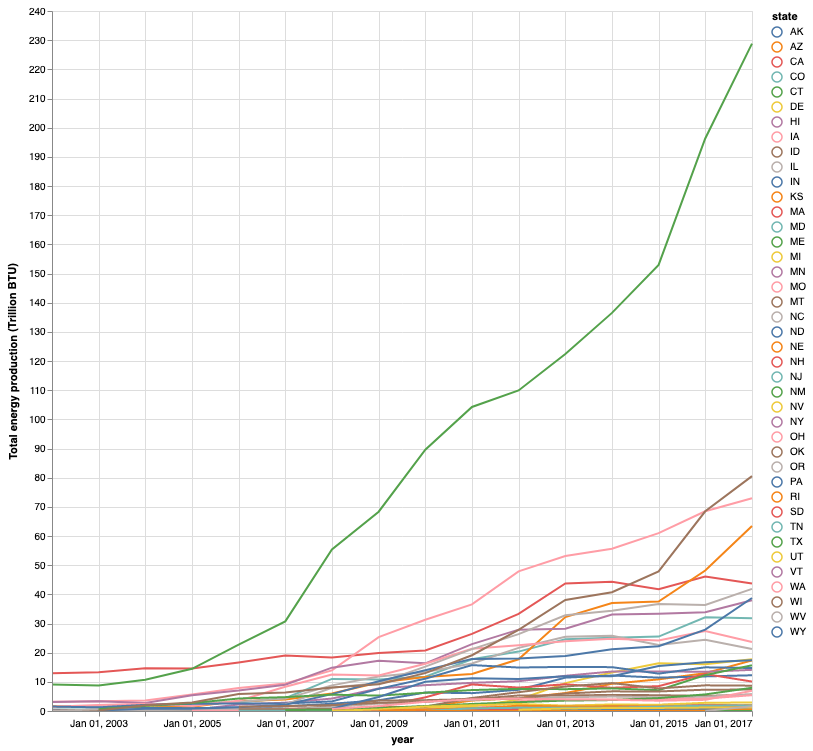

In [17]:
Axes({
    "mark": "line",
    "encoding": {
       "x": {
           "field": "year",
           "type": "temporal"
       },
        "y": {
            "field": "energy",
            "type": "quantitative",
            "axis": {"title": "Total energy production (Trillion BTU)"}
        },
        "color": {
            "field": "state"
        },
        "tooltip": {
            "field": "state"
        }
    },
    "height": 700,
    "width": 700
}, wind[wind.year > "01-01-2001"])

In [18]:
'''
wind_min = wind.groupby("state").energy.min()
wind_max = wind.groupby("state").energy.max()

wind["min"] = wind.state.map(wind_min)
wind["max"] = wind.state.map(wind_max)

wind["change"] = wind["max"] / wind["min"]
d = wind.groupby("state").change.first().sort_values().reset_index()
topten = b[b.change != np.inf].sort_values("change", ascending=False).iloc[0:9].state.values
e = wind[wind.state.isin(topten)]
'''

'\nwind_min = wind.groupby("state").energy.min()\nwind_max = wind.groupby("state").energy.max()\n\nwind["min"] = wind.state.map(wind_min)\nwind["max"] = wind.state.map(wind_max)\n\nwind["change"] = wind["max"] / wind["min"]\nd = wind.groupby("state").change.first().sort_values().reset_index()\ntopten = b[b.change != np.inf].sort_values("change", ascending=False).iloc[0:9].state.values\ne = wind[wind.state.isin(topten)]\n'

In [19]:
topten = wind[wind.year >= "2017-01-01"].sort_values("energy", ascending=False).iloc[0:9].state.values
e = wind[wind.state.isin(topten)]

## Highlight the top 10 states that have had the biggest % change in wind production over time, plot their lines by wind production in BTU over time. 

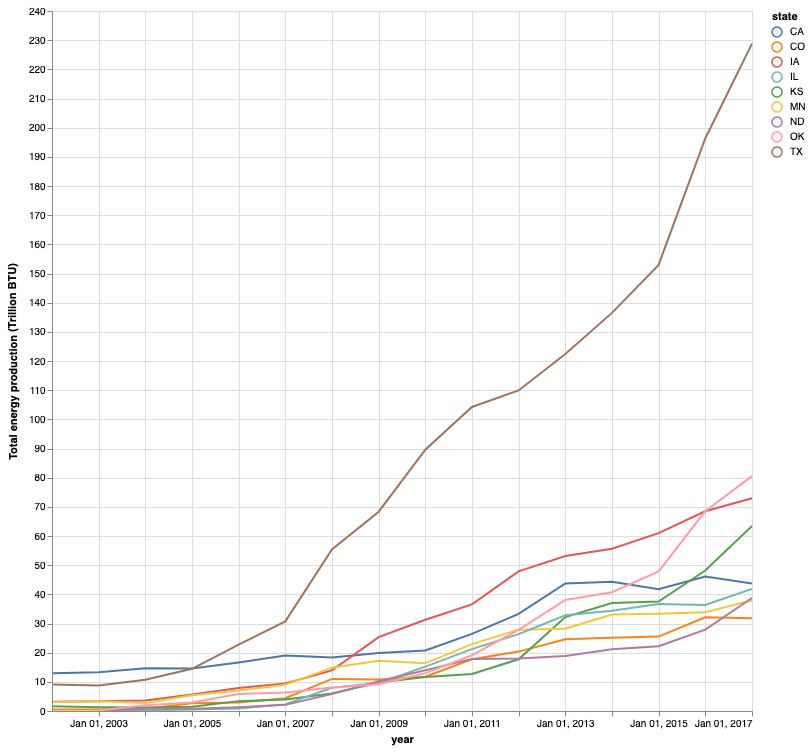

In [20]:
Axes({
    "mark": "line",
    "encoding": {
       "x": {
           "field": "year",
           "type": "temporal"
       },
        "y": {
            "field": "energy",
            "type": "quantitative",
            "axis": {"title": "Total energy production (Trillion BTU)"}
        },
        "color": {
            "field": "state"
        },
        "tooltip": {
            "field": "state"
        }
    },
    "height": 700,
    "width": 700
}, e[e.year > "01-01-2001"])

In [21]:
e[(e.year > start) & (e.year < end)].drop(["source"], axis=1).to_csv("../static/data/C.csv", 
                                                         header=True, index=False, float_format="%.3f")

## from these 10 states filter state with largest percent change in wind production and highlight all of their sources of energy production as percentages of their total production

In [22]:
f = states[states.state.isin(topten)]
f.source.unique()

array(['biomass', 'coal', 'crude oil', 'geothermal', 'hydro',
       'natural gas', 'nuclear', 'solar', 'wind'], dtype=object)

In [23]:
f_total = f.groupby(["state", "year"]).energy.sum().reset_index()
g = f.merge(f_total, left_on=["state", "year"], right_on=["state", "year"], how="left")\
        .rename({"energy_x": "energy", "energy_y": "total"}, axis=1)
g.head()

,year,state,source,energy,total
0,1990-01-01,CA,biomass,21.290542,565.65811
1,1990-01-01,CA,coal,8.999754,565.65811
2,1990-01-01,CA,crude oil,18.676783,565.65811
3,1990-01-01,CA,geothermal,49.546519,565.65811
4,1990-01-01,CA,hydro,84.545330,565.65811


In [24]:
g["share"] = g.energy / g.total
g[g.state == "KS"].head()

,year,state,source,energy,total,share
26,1990-01-01,KS,coal,80.933520,116.638732,0.693882
27,1990-01-01,KS,crude oil,0.252577,116.638732,0.002165
28,1990-01-01,KS,hydro,0.045154,116.638732,0.000387
29,1990-01-01,KS,natural gas,8.539577,116.638732,0.073214
30,1990-01-01,KS,nuclear,26.867750,116.638732,0.230350


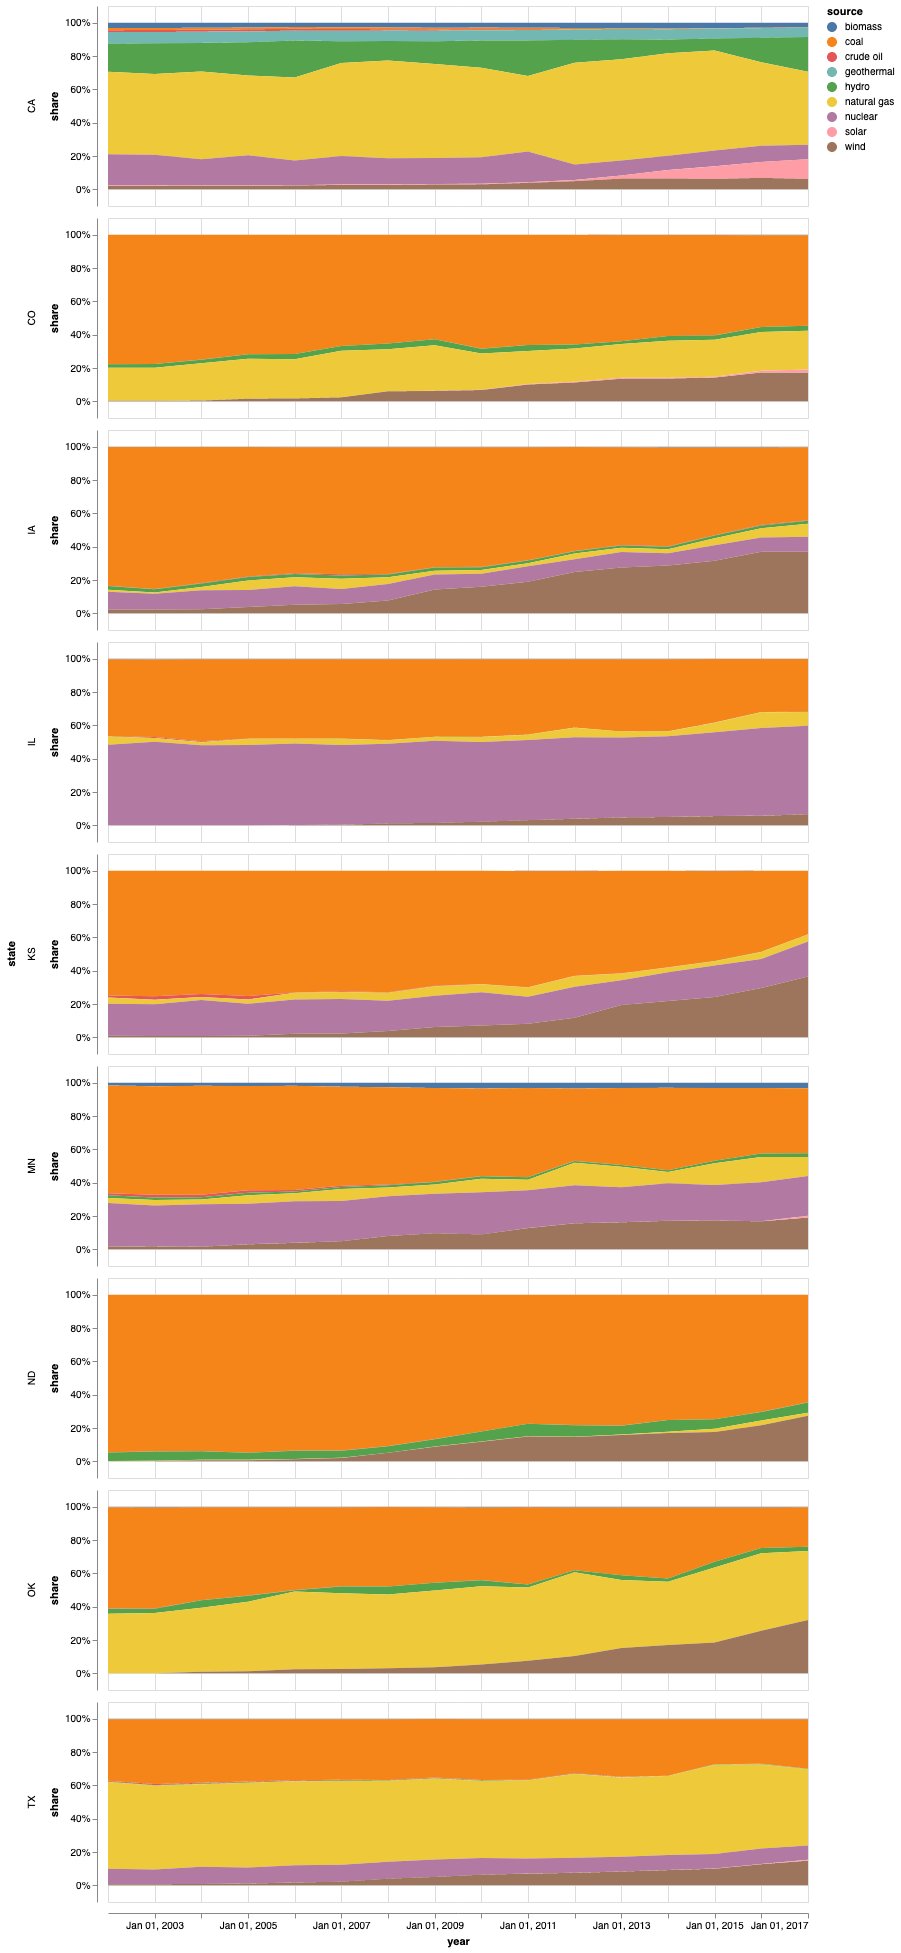

In [25]:
Axes({
    "mark": "area",
    "encoding": {
       "x": {
           "field": "year",
           "type": "temporal"
       },
        "y": {
            "field": "share",
            "type": "quantitative",
            "axis": {"format": ".0%"}
        },
        "color": {
            "field": "source"
        },
        "row": {
            "field": "state"
        }
    },
    "height": 200,
    "width": 700
}, g[g.year > "01-01-2001"])

In [26]:
h = g[(g.year > "01-01-2001") & (g.state == "CA")]
hh = h.drop(["state", "energy", "total"], axis=1).copy()
hh.share = hh.share * 100
h.head()

,year,state,source,energy,total,share
680,2002-01-01,CA,biomass,20.391299,627.166281,0.032513
681,2002-01-01,CA,coal,7.942484,627.166281,0.012664
682,2002-01-01,CA,crude oil,6.691157,627.166281,0.010669
683,2002-01-01,CA,geothermal,44.607174,627.166281,0.071125
684,2002-01-01,CA,hydro,105.429541,627.166281,0.168105


In [27]:
h_years = pd.to_datetime(pd.Series(list(range(2002, 2018))), format="%Y")
h_sources = pd.Series(h.source.unique())
idx = pd.MultiIndex.from_product((h_sources, h_years), names=['source', 'year'])
idx

MultiIndex(levels=[['biomass', 'coal', 'crude oil', 'geothermal', 'hydro', 'natural gas', 'nuclear', 'solar', 'wind'], [2002-01-01 00:00:00, 2003-01-01 00:00:00, 2004-01-01 00:00:00, 2005-01-01 00:00:00, 2006-01-01 00:00:00, 2007-01-01 00:00:00, 2008-01-01 00:00:00, 2009-01-01 00:00:00, 2010-01-01 00:00:00, 2011-01-01 00:00:00, 2012-01-01 00:00:00, 2013-01-01 00:00:00, 2014-01-01 00:00:00, 2015-01-01 00:00:00, 2016-01-01 00:00:00, 2017-01-01 00:00:00]],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

In [28]:
ha = hh.set_index(['source', 'year']).reindex(idx, fill_value=0).reset_index()

In [29]:
ha[(ha.year > start) & (ha.year < end)].to_csv("../static/data/D.csv", header=True, index=False, float_format="%.3f")

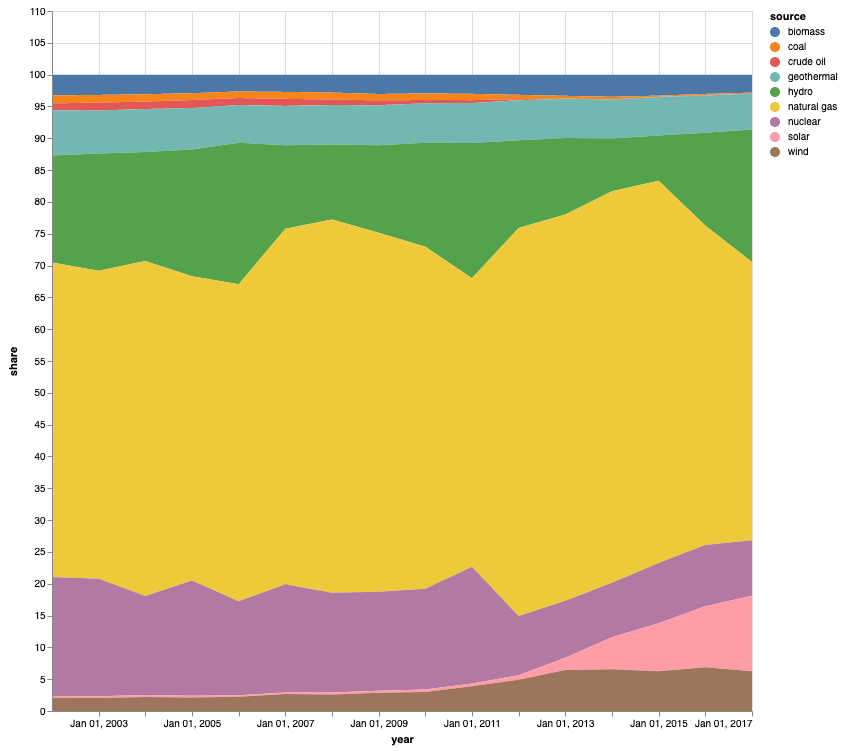

In [30]:
Axes({
    "mark": "area",
    "encoding": {
       "x": {
           "field": "year",
           "type": "temporal"
       },
        "y": {
            "field": "share",
            "type": "quantitative",
        },
        "color": {
            "field": "source"
        }
    },
    "height": 700,
    "width": 700
}, ha)

In [31]:
ha[ha.year == "01-01-2002"]

,source,year,share
0,biomass,2002-01-01,3.251339
16,coal,2002-01-01,1.266408
32,crude oil,2002-01-01,1.066887
48,geothermal,2002-01-01,7.112496
64,hydro,2002-01-01,16.810461
80,natural gas,2002-01-01,49.433190
96,nuclear,2002-01-01,18.688853
112,solar,2002-01-01,0.301597
128,wind,2002-01-01,2.068769


In [32]:
ha[ha.year == "01-01-2017"]

,source,year,share
15,biomass,2017-01-01,2.829106
31,coal,2017-01-01,0.141781
47,crude oil,2017-01-01,0.022306
63,geothermal,2017-01-01,5.630287
79,hydro,2017-01-01,20.832116
95,natural gas,2017-01-01,43.718326
111,nuclear,2017-01-01,8.719012
127,solar,2017-01-01,11.861484
143,wind,2017-01-01,6.245582


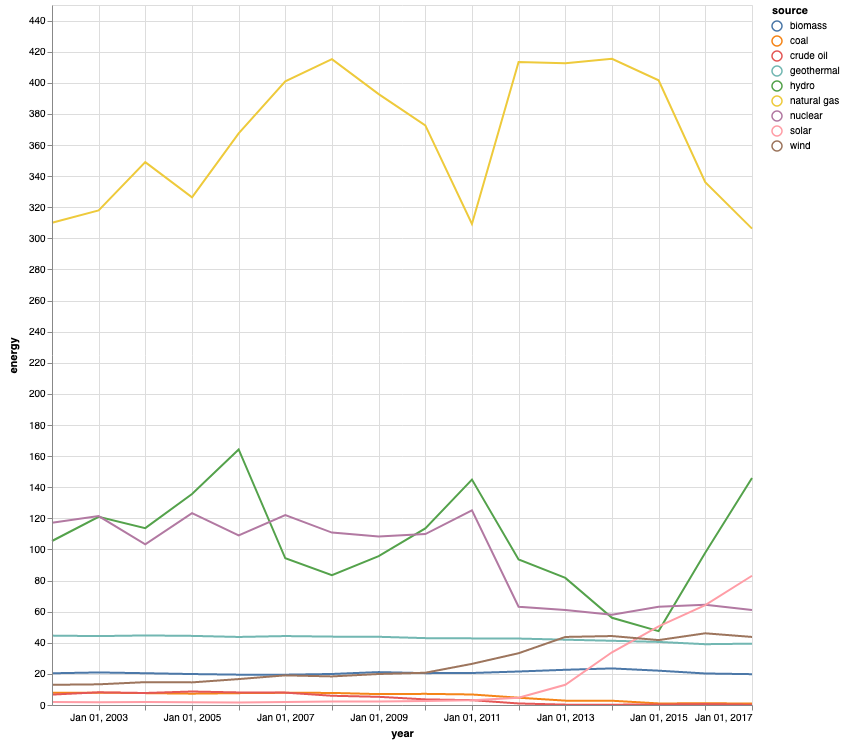

In [33]:
Axes({
    "mark": "line",
    "encoding": {
       "x": {
           "field": "year",
           "type": "temporal"
       },
        "y": {
            "field": "energy",
            "type": "quantitative",
        },
        "color": {
            "field": "source"
        }
    },
    "height": 700,
    "width": 700
}, h)

In [34]:
h.drop(["total", "share", "state"], axis=1)\
    .to_csv("../static/data/E.csv", header=True, index=False, float_format="%.3f")

## from these 10 states, show their proportion of installed wind capacity relative to installed+proportion wind capacity.

In [20]:
potential = pd.read_excel("wind-capacity-mw.xlsx", sheet_name="Gen by TRG by State 2015")
pot = potential.melt(id_vars="State").groupby("State").value.sum().reset_index()
pot.value = pot.value * 1000
pot.head()

,State,value
0,AL,2.630690e+08
1,AR,3.882356e+08
2,AZ,8.843440e+08
3,CA,4.979829e+08
4,CO,1.156681e+09


In [21]:
eff = states[(states.year == "2015-01-01") 
             & (states.source == "Wind")
            & (states.producer == "Total Electric Power Industry")].drop(["year", "source", "producer"], axis=1)
eff.head()

,state,amount
43309,AK,159694.0
43415,AZ,452035.0
43451,CA,12229559.0
43509,CO,7475279.0
43602,DE,5126.0


In [22]:
h = eff.merge(pot, left_on="state", right_on="State", how="inner")\
    .rename({"amount": "effective", "value": "potential"},axis=1)\
    .drop(["State"], axis=1)
h["total"] = h.effective + h.potential
i = h.copy()
i["effective"] = h.effective / h.total
i["potential"] = h.potential / h.total
i.drop(["total"], inplace=True, axis=1)
i

,state,effective,potential
0,AZ,0.000511,0.999489
1,CA,0.023970,0.976030
2,CO,0.006421,0.993579
3,DE,0.003119,0.996881
4,IA,0.016576,0.983424
5,ID,0.005077,0.994923
6,IL,0.017768,0.982232
7,IN,0.012706,0.987294
8,KS,0.005335,0.994665
9,MA,0.022183,0.977817


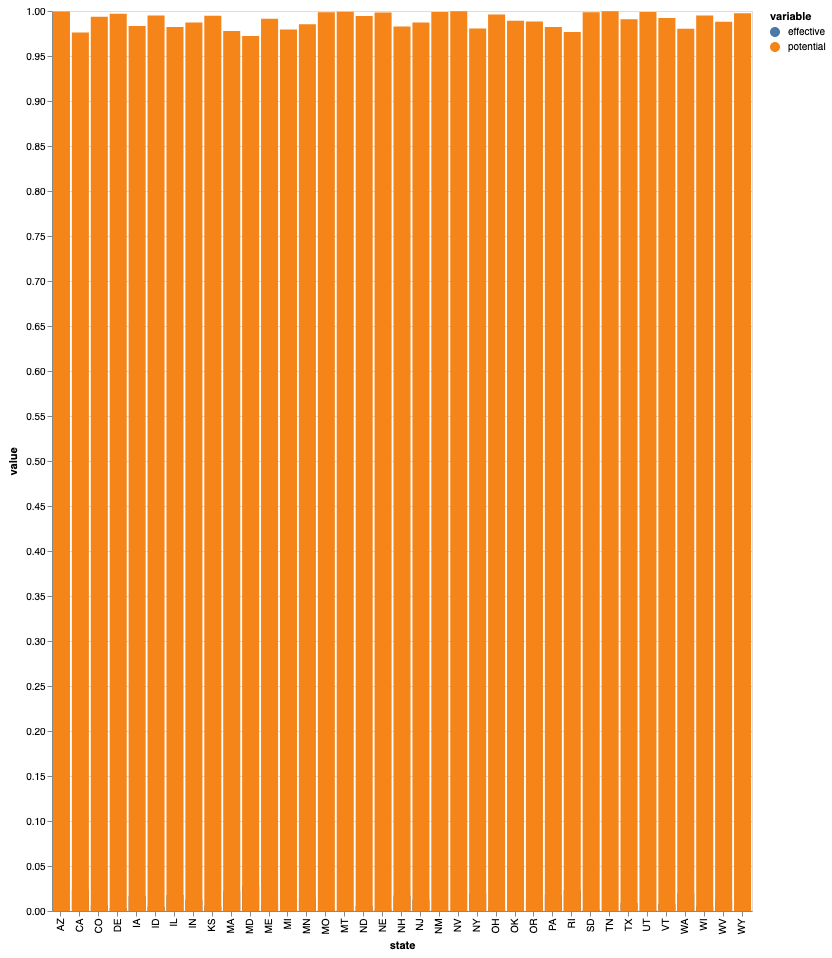

In [23]:
Axes({
    "mark": "rect",
    "encoding": {
       "y": {
           "field": "value",
           "type": "quantitative"
       },
        "x": {
            "field": "state",
            "type": "nominal",
        },
        "color": {
            "field": "variable",
            "type": "nominal"
        },
    },
    "height": 900,
    "width": 700
}, i.melt(id_vars="state"))